In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az

from sklearn.metrics import mean_squared_error as MSE

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_theme()

In [2]:
data = pd.read_csv("datasets/leinhardt.csv")

data = data[data["infant"].isna() == False]

data["loginfant"] = np.log(data["infant"])
data["logincome"] = np.log(data["income"])

Scale the predictors as suggested by Gelman, Hill in Data Analysis Using Regression and Multilevel/Hierarchical Models (2006)

In [3]:
def scaler(X:np.array):
    stddev = np.std(X)
    mean = np.mean(X)

    return (X - mean) / (2*stddev)

y = np.log(data["infant"].to_numpy())
x = scaler(np.log(data["income"].to_numpy()))

data["scaledincome"] = x

oil, oil_value = pd.factorize(data["oil"])
region, region_name = pd.factorize(data["region"])

<AxesSubplot: xlabel='logincome', ylabel='loginfant'>

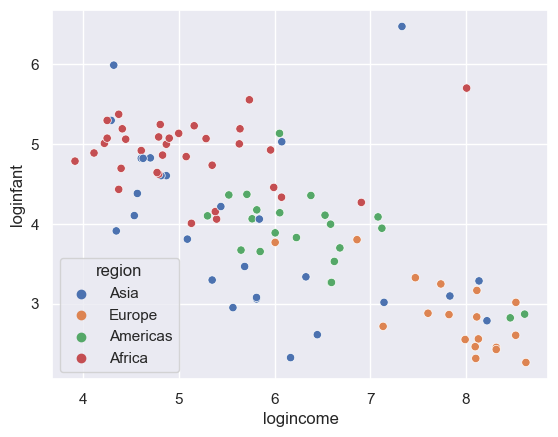

In [4]:
sns.scatterplot(data=data, x="logincome", y="loginfant", hue="region")

/Users/btb/Projects/bayesian_notebooks/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/btb/Projects/bayesian_notebooks/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/btb/Projects/bayesian_notebooks/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/btb/Projects/bayesian_notebooks/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


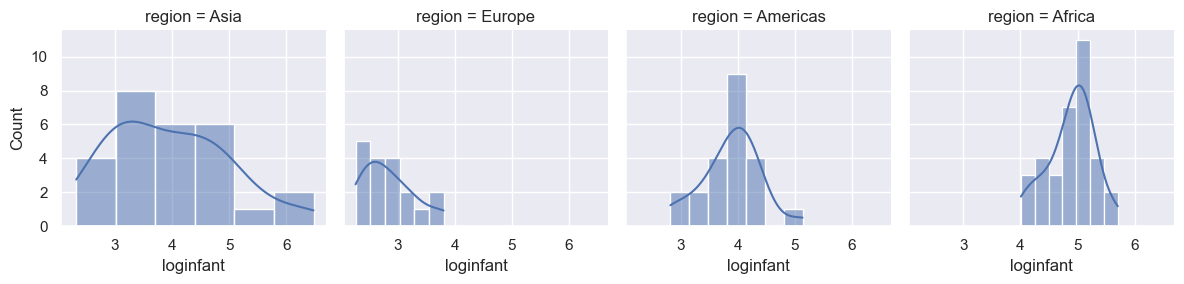

In [5]:
g = sns.FacetGrid(data, col="region")
g.map(sns.histplot, "loginfant", kde=True)

## Complete Pooling - no difference between regions
A regression against all the regions together

In [6]:
with pm.Model() as model_regression:

    beta_0 = pm.Normal("beta_0", mu=0, sigma=10)
    beta_1 = pm.Normal("beta_1", mu=0, sigma=10)
    beta_2 = pm.Normal("beta_2", mu=0, sigma=10)

    sigma = pm.Gamma("sigma", mu=2, sigma=2)

    predicted = beta_0 + beta_1 * x + beta_2 * oil

    obs = pm.Normal("obs", mu=predicted, sigma=sigma, observed=y)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 6 seconds.


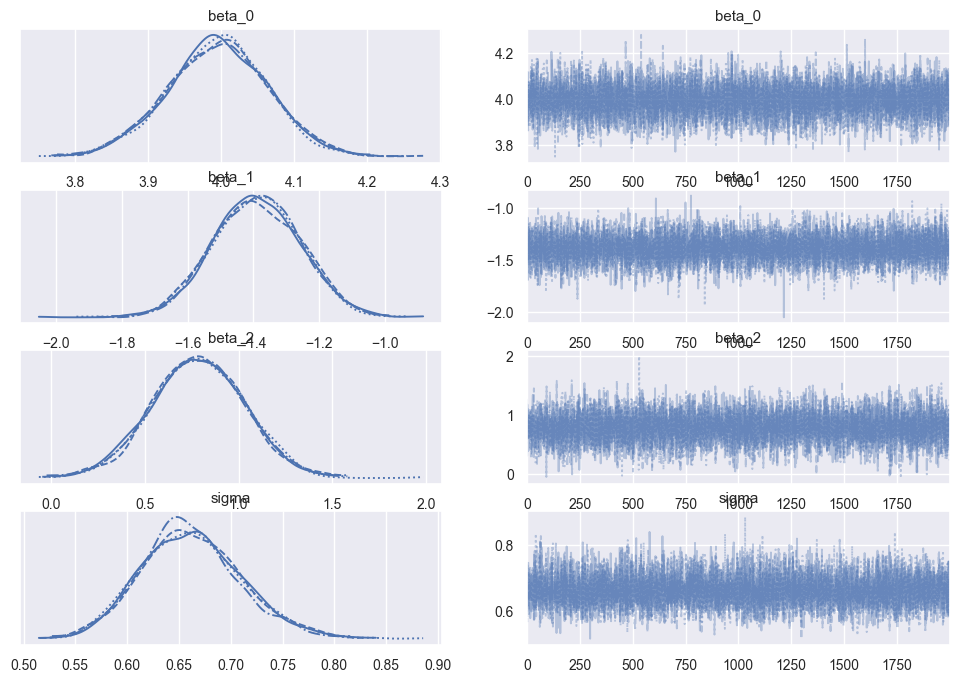

In [7]:
with model_regression:
    trace_regression = pm.sample(2000, target_accept=0.95)
    pm.plot_trace(trace_regression)

## No Pooling
An independent regression for each region

In [8]:
with pm.Model() as model_region:

    alpha = pm.Normal("alpha", mu=0, sigma=10, shape=len(region_name))
    beta_1 = pm.Normal("beta_1", mu=0, sigma=10, shape=len(region_name))

    error = pm.Exponential("error", 1)

    obs = pm.Normal("obs", mu=alpha[region] + beta_1[region] * x, sigma=error, observed=y)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_1, error]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 7 seconds.


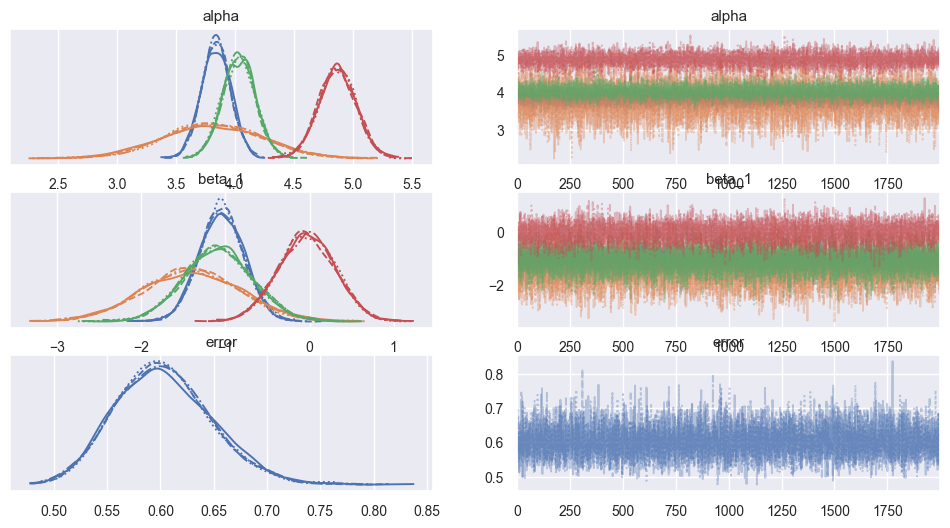

In [9]:
with model_region:
    trace_region = pm.sample(2000)
    pm.plot_trace(trace_region)

In [10]:
with pm.Model() as model_heirarchical:

    theta_a = pm.Normal("theta_a", mu=0, sigma=10)
    sigma_a = pm.Gamma("sigma_a", mu=2, sigma=2)
    a_ = pm.Normal("a_", mu=0, sigma=1, shape=len(region_name))
    
    alpha = pm.Deterministic("alpha", theta_a + a_ * sigma_a)
    
    beta_1 = pm.Normal("beta_1", mu=0, sigma=10)
    beta_2 = pm.Normal("beta_2", mu=0, sigma=10)

    resp = alpha[region] + beta_1 * x + beta_2 * oil

    sigma_y = pm.Exponential("sigma_y", 1)

    obs = pm.Normal("obs", mu=resp, sigma=sigma_y, observed=y)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_a, sigma_a, a_, beta_1, beta_2, sigma_y]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


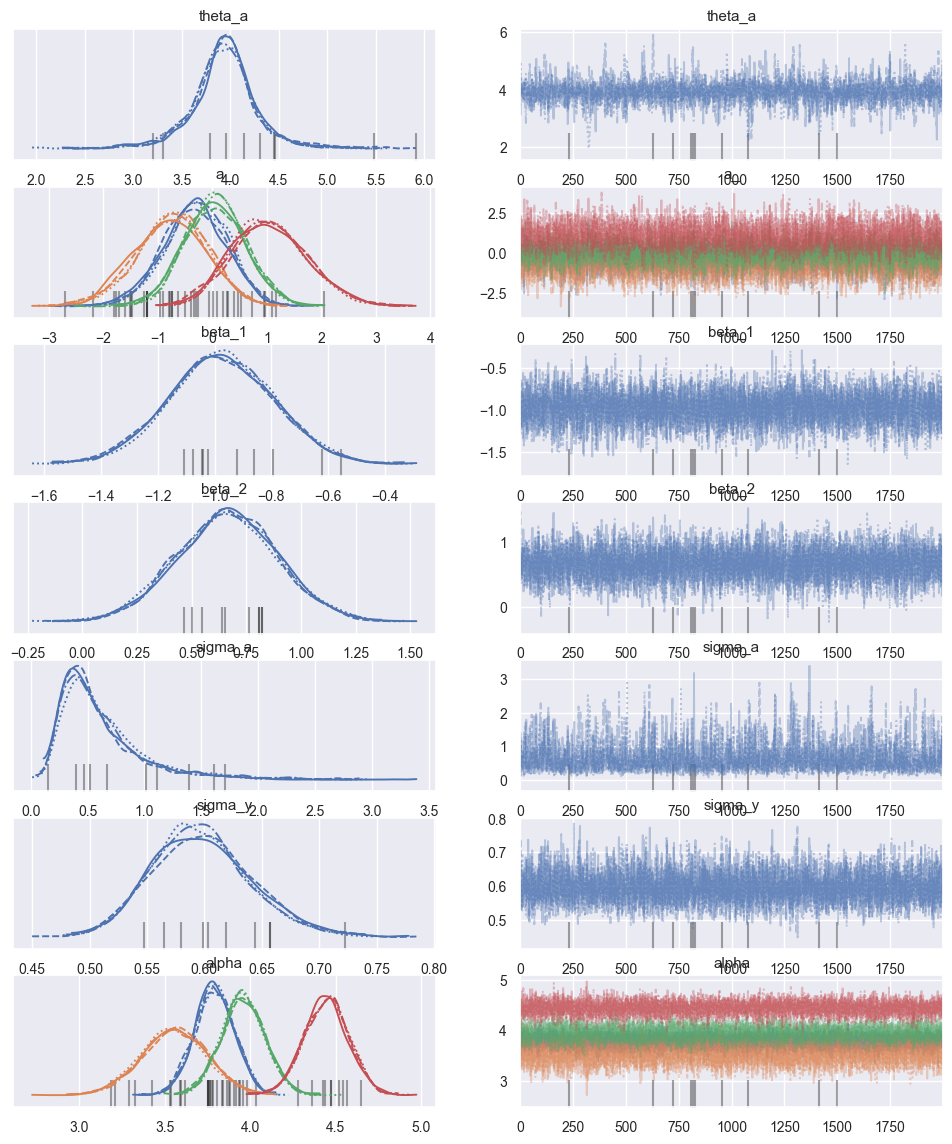

In [11]:
with model_heirarchical:
    trace_heirarchical = pm.sample(2000, target_accept=0.95)
    pm.plot_trace(trace_heirarchical)

In [12]:
with pm.Model() as model_vary_slopes:

    theta_a = pm.Normal("theta_a", mu=0, sigma=10)
    sigma_a = pm.Gamma("sigma_a", mu=2, sigma=2)
    a_ = pm.Normal("a_", mu=0, sigma=1, shape=len(region_name))
    
    theta_b = pm.Normal("theta_b", mu=0, sigma=10)
    sigma_b = pm.Gamma("sigma_b", mu=2, sigma=2)
    b_ = pm.Normal("b_", mu=0, sigma=1, shape=len(region_name))


    alpha = pm.Deterministic("alpha", theta_a + a_ * sigma_a)
    beta_1 = pm.Deterministic("beta_1", theta_b + b_ * sigma_b)

    beta_2 = pm.Normal("beta_2", mu=0, sigma=10)

    resp = alpha[region] + beta_1[region] * x + beta_2 * oil

    sigma_y = pm.Exponential("sigma_y", 1)

    obs = pm.Normal("obs", mu=resp, sigma=sigma_y, observed=y)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_a, sigma_a, a_, theta_b, sigma_b, b_, beta_2, sigma_y]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


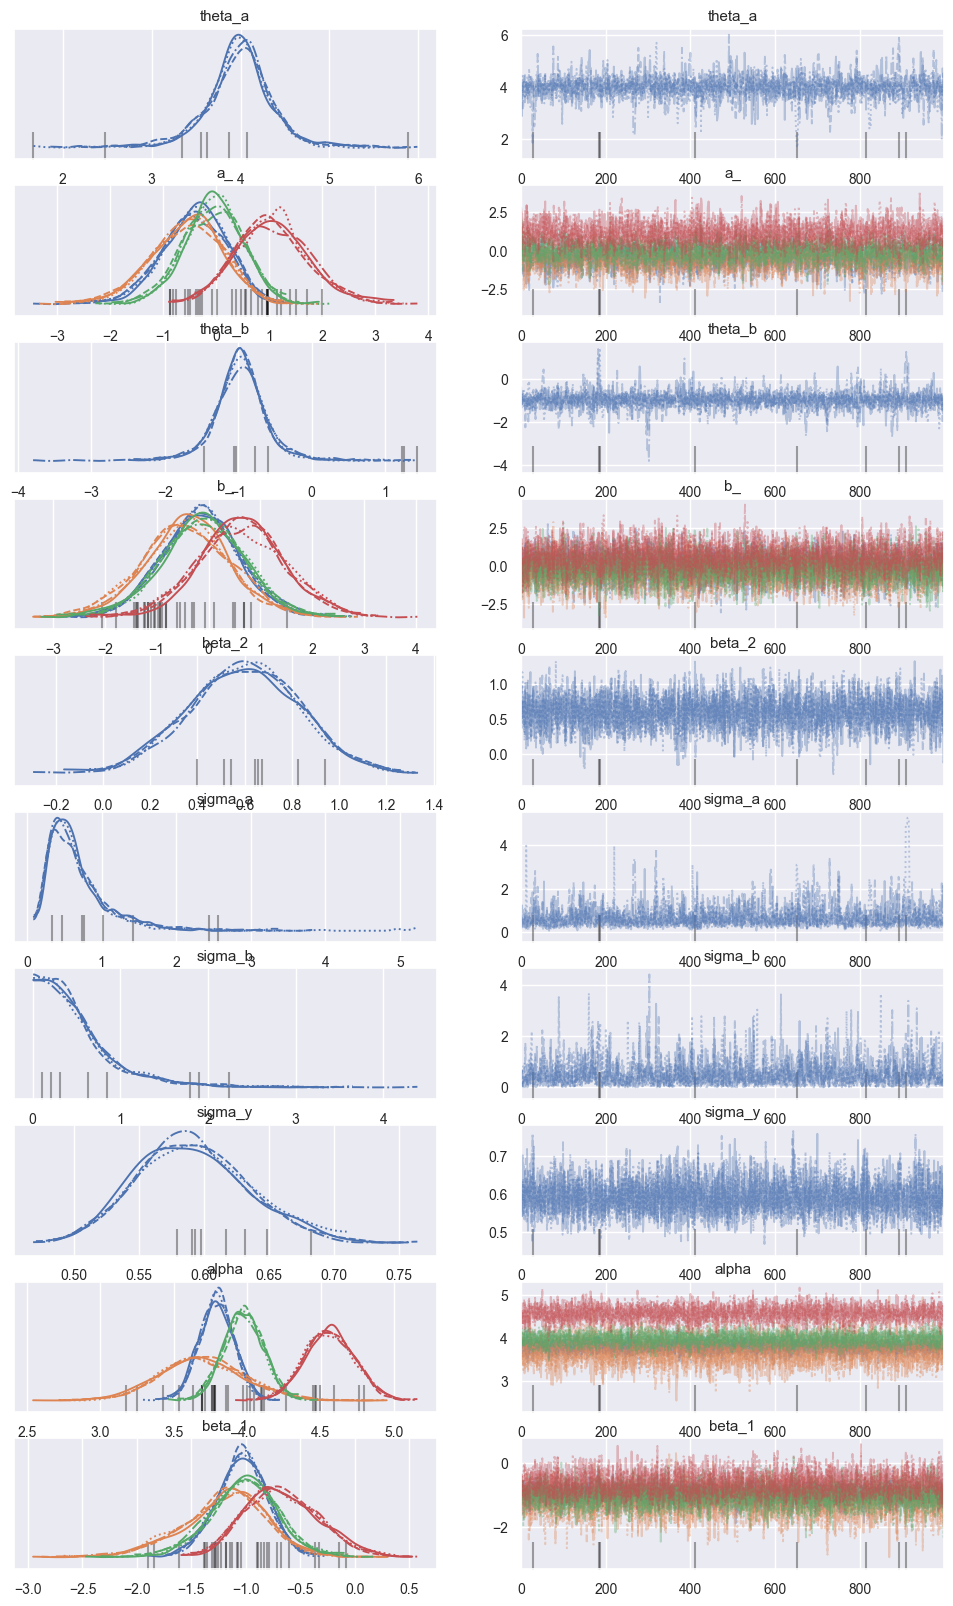

In [13]:
with model_vary_slopes:
    trace_vary_slopes = pm.sample(target_accept=0.95)
    pm.plot_trace(trace_vary_slopes)

In [14]:
with model_regression:
    regression_obs = pm.sample_posterior_predictive(trace_regression)
with model_region:
    region_obs = pm.sample_posterior_predictive(trace_region)
with model_heirarchical:
    heirarchical_obs = pm.sample_posterior_predictive(trace_heirarchical)
with model_vary_slopes:
    vary_slopes_obs = pm.sample_posterior_predictive(trace_vary_slopes)

In [15]:
print("Regression Model:                      {:.5f}".format(MSE(y, regression_obs.posterior_predictive.obs.mean(dim=["chain","draw"]))))
print("Region Model:                          {:.5f}".format(MSE(y, region_obs.posterior_predictive.obs.mean(dim=["chain","draw"]))))
print("Region Heirarchical Model:             {:.5f}".format(MSE(y, heirarchical_obs.posterior_predictive.obs.mean(dim=["chain","draw"]))))
print("Varying Slopes Model:                  {:.5f}".format(MSE(y, vary_slopes_obs.posterior_predictive.obs.mean(dim=["chain","draw"]))))

Regression Model:                      0.41804
Region Model:                          0.32723
Region Heirarchical Model:             0.32915
Varying Slopes Model:                  0.31791


In [16]:
alphas = trace_vary_slopes.posterior.mean(dim=["chain","draw"])["alpha"]
betas = trace_vary_slopes.posterior.mean(dim=["chain","draw"])["beta_1"]

regression_a = trace_regression.posterior.mean(dim=["chain","draw"])["beta_0"]
regression_b = trace_regression.posterior.mean(dim=["chain","draw"])["beta_1"]

alphas_region = trace_region.posterior.mean(dim=["chain","draw"])["alpha"]
betas_region = trace_region.posterior.mean(dim=["chain","draw"])["beta_1"]

/Users/btb/Projects/bayesian_notebooks/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/btb/Projects/bayesian_notebooks/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/btb/Projects/bayesian_notebooks/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/btb/Projects/bayesian_notebooks/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


<xarray.DataArray 'alpha' ()>
array(3.79194264)
Coordinates:
    alpha_dim_0  int64 0 <xarray.DataArray 'beta_1' ()>
array(-1.04394969)
Coordinates:
    beta_1_dim_0  int64 0
<xarray.DataArray 'alpha' ()>
array(3.71578139)
Coordinates:
    alpha_dim_0  int64 1 <xarray.DataArray 'beta_1' ()>
array(-1.23422515)
Coordinates:
    beta_1_dim_0  int64 1
<xarray.DataArray 'alpha' ()>
array(3.97602752)
Coordinates:
    alpha_dim_0  int64 2 <xarray.DataArray 'beta_1' ()>
array(-1.02753731)
Coordinates:
    beta_1_dim_0  int64 2
<xarray.DataArray 'alpha' ()>
array(4.56084189)
Coordinates:
    alpha_dim_0  int64 3 <xarray.DataArray 'beta_1' ()>
array(-0.66314479)
Coordinates:
    beta_1_dim_0  int64 3


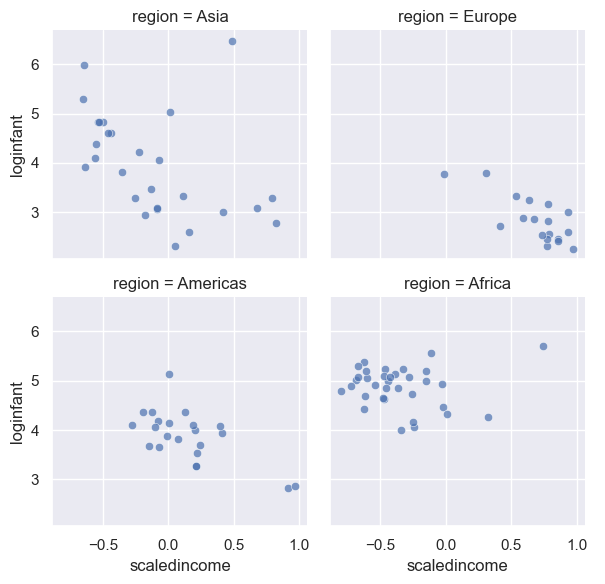

In [26]:
x_ = np.linspace(np.min(x), np.max(x))

g = sns.FacetGrid(data, col="region", col_wrap=2)
g.map(sns.scatterplot, "scaledincome", "loginfant", alpha=.7)
g.add_legend()

for ax, alpha_, beta_ in zip(g.axes_dict.values(), alphas, betas):
    print(alpha_, beta_)
    # y_ = alpha_ + beta_ * x_
    # ax.plot(x_,y_)


for ax, alpha_, beta_ in zip(g.axes_dict.values(), alphas_region, betas_region):
    pass
    # y_ = alpha_ + beta_ * x_
    # ax.plot(x_,y_, linestyle='--')

for ax in g.axes_dict.values():
    pass
    # y_ = regression_a + regression_b * x_
    # ax.plot(x_,y_, '--')

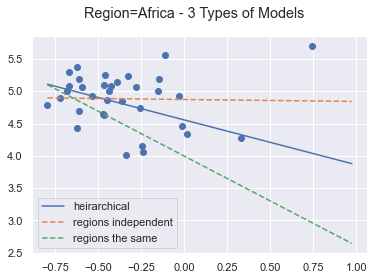

In [18]:
x_plot = data[data["region"] == "Africa"]["scaledincome"]
y_plot = data[data["region"] == "Africa"]["loginfant"]

fig, ax = plt.subplots()
fig.suptitle("Region=Africa - 3 Types of Models")

ax.scatter(x_plot, y_plot)

y_ = alphas[3] + betas[3] * x_
ax.plot(x_,y_, label="heirarchical")

y_ = alphas_region[3] + betas_region[3] * x_
ax.plot(x_,y_, linestyle='--', label="regions independent")

y_ = regression_a + regression_b * x_
ax.plot(x_,y_, linestyle='--', label="regions the same")

ax.legend()

In [19]:
y_hat = np.mean(vary_slopes_obs["obs"], axis=0)
data["residual"] = y - y_hat

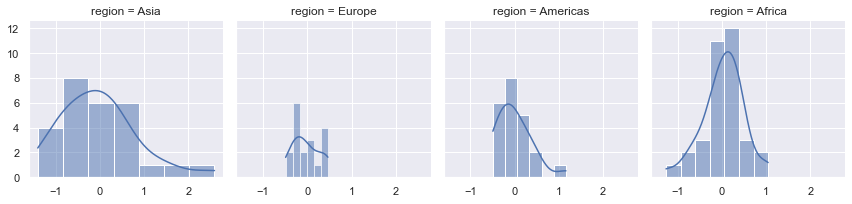

In [20]:
g = sns.FacetGrid(data, col="region")
g.map_dataframe(sns.histplot, x="residual", kde=True)

Text(0.5, 0.98, 'Infant Mortality vs. Income - Multilevel Fit')

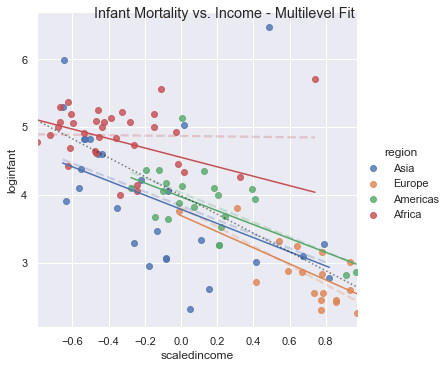

In [35]:
g = sns.lmplot(data=data, x="scaledincome", y="loginfant", hue="region", ci=None, line_kws={"linestyle":"dashed", "alpha":0.25})

for region, alpha_, beta_ in zip(region_name, alphas, betas):
    x = data[data["region"] == region]["scaledincome"]
    # y = data[data["region"] == region]["loginfant"]

    x_ = np.linspace(np.min(x), np.max(x))

    y_ = alpha_ + beta_ * x_
    plt.plot(x_,y_)

x_ = np.linspace(np.min(data["scaledincome"]), np.max(data["scaledincome"]))
y_ = regression_a + regression_b*x_

plt.plot(x_, y_, color="black", linestyle="dotted", alpha=0.5)

plt.suptitle("Infant Mortality vs. Income - Multilevel Fit")
